WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
C:\Users\sbezo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[-98.17086885   1.44984922]


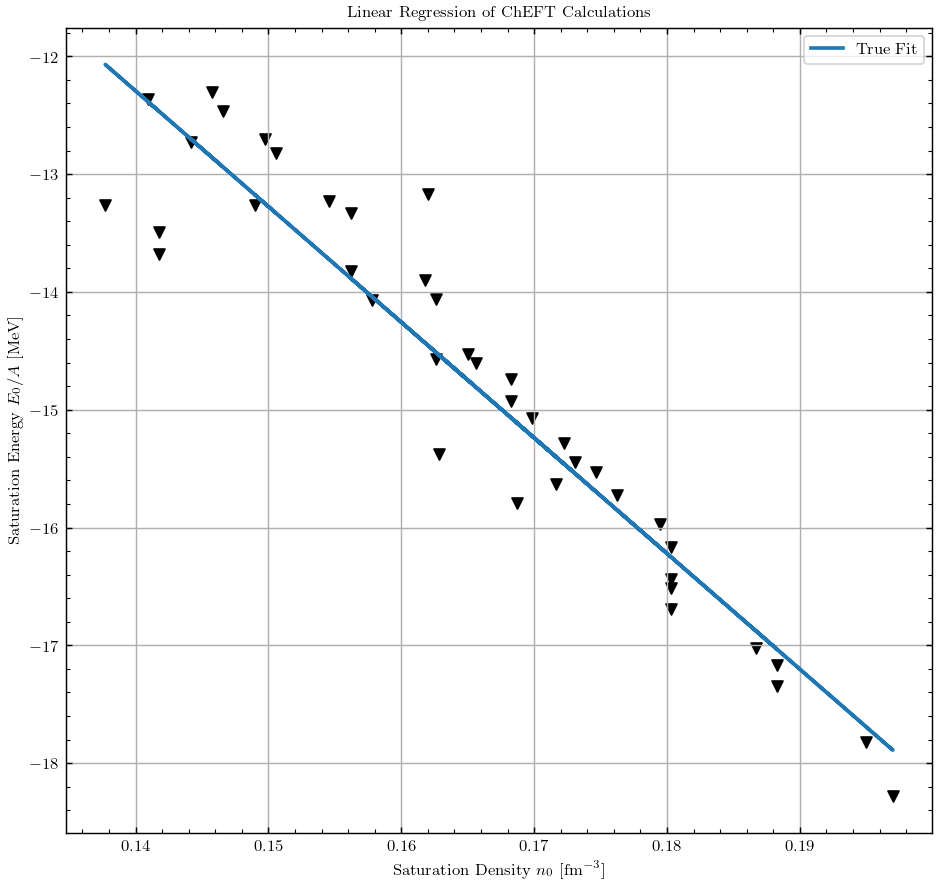

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from plot_helpers import *

dtypes = {"hamiltonian": str, "hamiltonian_brief": str, "n0": np.float64, "En0": np.float64, "method": str, \
          "mbpt_order": np.float64,"set_id": str, "reference": str}
mytypes = {"n0": np.float64, "En0": np.float64}
dt = pd.read_csv("data/saturation_points.csv", comment = "#", usecols=[2,3])

x = dt["n0"]
y = dt["En0"]
                 

reg = np.polyfit(x, y, 1)  #TODO: not sure if 1/y is correct weights value
print(reg)

plt.figure(figsize=(8.6, 8.2))
plt.scatter(x, y, c='black', marker='v')
plt.title(label='Linear Regression of ChEFT Calculations')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0, label="True Fit")
plt.grid(True)
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')
plt.legend()
plt.legend(loc='upper right')
plt.savefig("LinRegChEFT.pdf")
plt.show()

In [2]:
dtypes={"Label":str, "rho0":np.float64, "E/aA": np.float64}
data_skyrme=pd.read_csv("data/satpoints_skyrme.csv", comment="#", dtype=dtypes)
data_rmf=pd.read_csv("data/satpoints_rmf.csv", comment="#", dtype=dtypes)
data_FC1=pd.read_csv("data/forChristan_samples1.csv",comment="#", names=["rho0","E/A"])
data_FC2=pd.read_csv("data/forChristan_samples2.csv",comment="#", names=["rho0","E/A"])
data_FC3=pd.read_csv("data/forChristan_samples3.csv",comment="#", names=["rho0","E/A"])

def import_fwf_data(filepath, column_name):
    data = pd.read_fwf(filepath, skiprows=7, comment='#', usecols=column_name)
    return data.rename(columns={column_name[0]:"rho0", column_name[1]:"E/A"})
                       
data_RMF012_1 = import_fwf_data("saturation/RMF012/CovEllipse.out", ["A39","B39"])
data_RMF012_2 = import_fwf_data("saturation/RMF012/CovEllipse.out", ["A95","B95"])
data_RMF016_1 = import_fwf_data("saturation/RMF016/CovEllipse.out", ["A39","B39"])
data_RMF016_2 = import_fwf_data("saturation/RMF016/CovEllipse.out", ["A95","B95"])
data_RMF022_1 = import_fwf_data("saturation/RMF022/CovEllipse.out", ["A39","B39"])
data_RMF022_2 = import_fwf_data("saturation/RMF022/CovEllipse.out", ["A95","B95"])
data_RMF028_1 = import_fwf_data("saturation/RMF028/CovEllipse.out", ["A39","B39"])
data_RMF028_2 = import_fwf_data("saturation/RMF028/CovEllipse.out", ["A95","B95"])
data_RMF032_1 = import_fwf_data("saturation/RMF032/CovEllipse.out", ["A39","B39"])
data_RMF032_2 = import_fwf_data("saturation/RMF032/CovEllipse.out", ["A95","B95"])

def insert_type(typename, data):
    data["type"]=typename
    return data

insert_type("Skyrme", data_skyrme)
insert_type("RMF", data_rmf)


def insert_type_and_label(typename, labelname, data):
    data["type"]=typename
    data["Label"]=labelname
    return data

insert_type_and_label("Schunck", "UNDEF", data_FC1)
insert_type_and_label("Schunck", "UNDEF", data_FC2)
insert_type_and_label("Schunck", "UNDEF", data_FC3)
insert_type_and_label("RMF012", "temp", data_RMF012_1)
insert_type_and_label("RMF012", "temp", data_RMF012_2)
insert_type_and_label("RMF016", "temp", data_RMF016_1)
insert_type_and_label("RMF016", "temp", data_RMF016_2)
insert_type_and_label("RMF022", "temp", data_RMF022_1)
insert_type_and_label("RMF022", "temp", data_RMF022_2)
insert_type_and_label("RMF028", "temp", data_RMF028_1)
insert_type_and_label("RMF028", "temp", data_RMF028_2)
insert_type_and_label("RMF032", "temp", data_RMF032_1)
insert_type_and_label("RMF032", "temp", data_RMF032_2)



data=pd.concat([data_skyrme, data_rmf, data_FC1, data_FC2, data_FC3, data_RMF012_1, data_RMF012_2, data_RMF016_1, data_RMF016_2, data_RMF022_1, data_RMF022_2, data_RMF028_1, data_RMF028_2, data_RMF032_1, data_RMF032_2])

data.tail(n=10000)

,Label,rho0,E/A,type
1010,UNDEF,0.156448,-15.759098,Schunck
1011,UNDEF,0.155968,-15.777481,Schunck
1012,UNDEF,0.155016,-15.728392,Schunck
1013,UNDEF,0.155568,-15.787707,Schunck
1014,UNDEF,0.155624,-15.750071,Schunck
...,...,...,...,...
496,temp,0.150937,-16.348962,RMF032
497,temp,0.150931,-16.348309,RMF032
498,temp,0.150925,-16.347656,RMF032
499,temp,0.150919,-16.347002,RMF032


C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


C:\Users\sbezo\AppData\Local\Temp\ipykernel_23612\2211619761.py:10: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1000, step, start=start, progressbar=False)
C:\Users\sbezo\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$P(\sigma)$, $P(\beta_1)$, $P(\beta_0)$]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to

{'$P(\\beta_0)$': 2.6538468099207027, '$P(\\beta_1)$': -105.82828117876625, '$P(\\sigma)$_log__': -0.7798128737728848, '$P(\\sigma)$': 0.4584917991189307}


C:\Users\sbezo\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:214: UserWarning: A valid var_name should be provided, found {'s', 'b'} expected from {'$P(\\sigma)$', '$P(\\beta_0)$', '$P(\\beta_1)$'}
  warnings.warn(


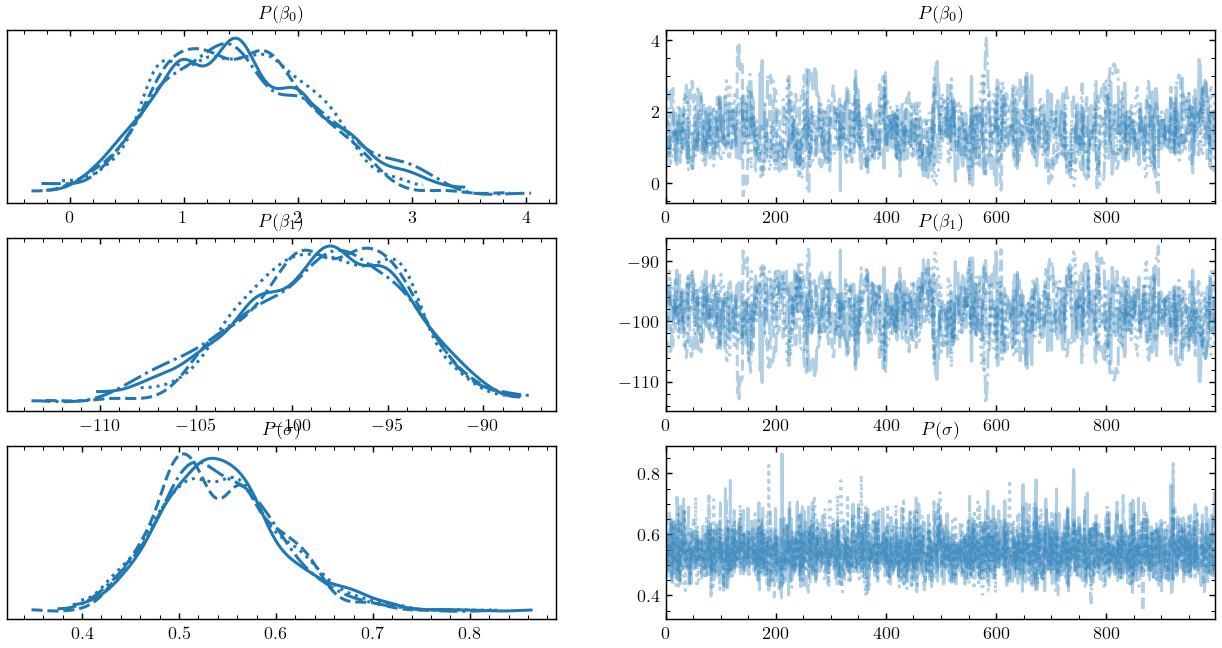

<Figure size 1040x1300 with 0 Axes>

In [3]:
 with pm.Model() as model:
        
    beta_0 = pm.Normal('$P(\\beta_0)$', mu=1.5, sd=1)
    beta_1 = pm.Normal('$P(\\beta_1)$', mu=-100, sd=50)
    sigma = pm.InverseGamma('$P(\sigma)$', alpha=6, beta=5) #mean = 1 varience = .5^2
    y_est =  beta_0 + beta_1 * x
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(1000, step, start=start, progressbar=False)
    print(trace[0])
    fig = pm.traceplot(trace, lines={'beta_0': 4, 'beta_1': 2, 'sigma': 2})
    plt.figure(figsize=(8, 10))
    plt.show()

In [15]:
with model:
    dt = az.summary(trace, kind='stats')
    plt.savefig("SummaryChEFT.pdf")
    display(dt)

,mean,sd,hdi_3%,hdi_97%
$P(\beta_0)$,1.423,0.677,0.178,2.668
$P(\beta_1)$,-98.013,4.088,-105.285,-90.322
$P(\sigma)$,0.541,0.063,0.425,0.658


<Figure size 720x480 with 0 Axes>

ValueError: Argument `ref_val` must be None, a constant, a list or a dictionary like {"var_name": [{"ref_val": ref_val}]}

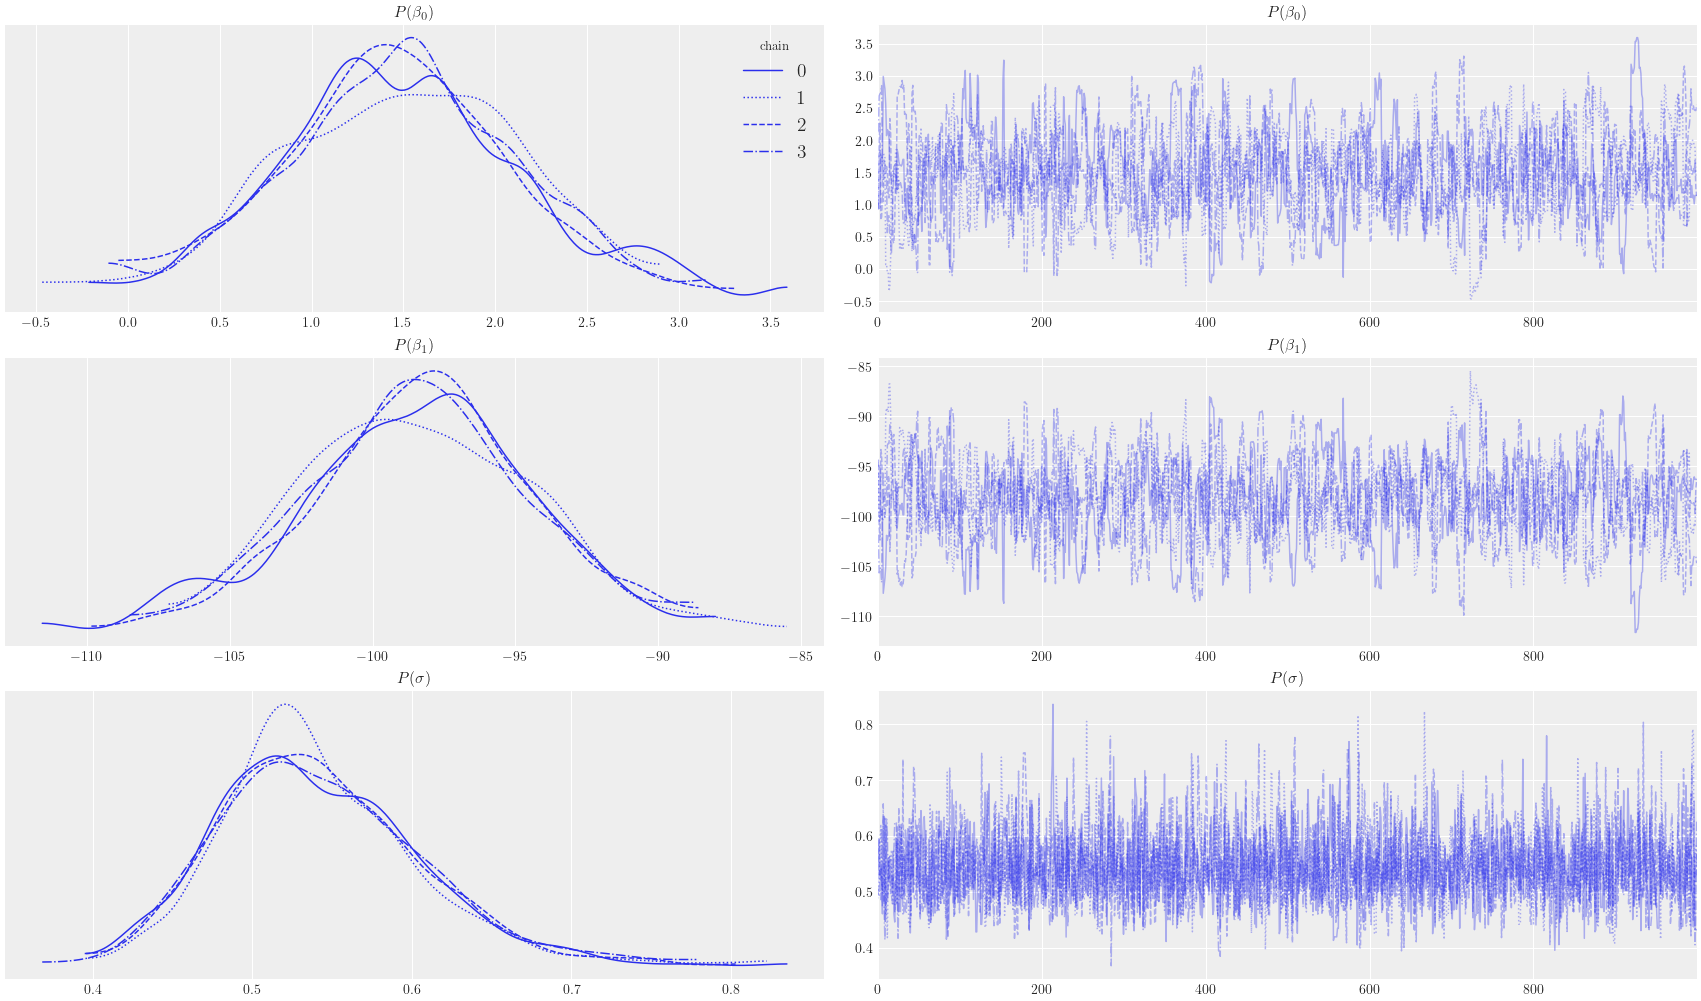

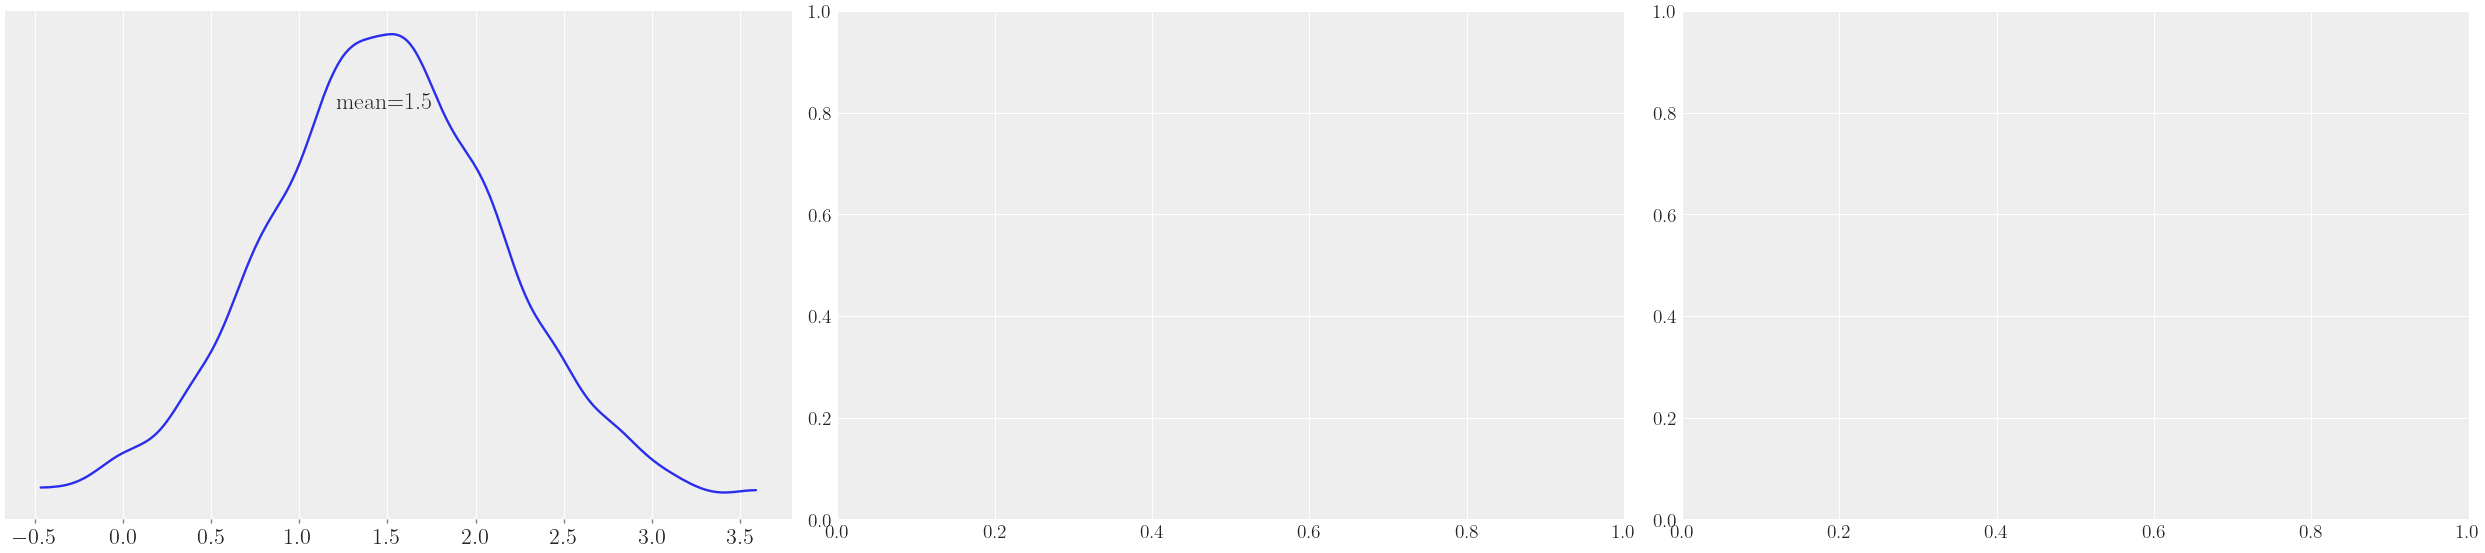

In [31]:
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42, progressbar=True)

with model: 
    trace_updated = az.from_pymc3(trace, posterior_predictive=ppc)
    az.style.use("arviz-darkgrid")
    
with model:
    az.plot_trace(trace_updated, figsize=(17, 10), legend=True)
plt.savefig("SamplerChEFT.pdf")


az.style.use("arviz-darkgrid")
with model:
    az.plot_posterior(trace_updated,textsize=16, hdi_prob='hide', ref_val='mean')

plt.savefig("PosteriorsChEFT.pdf")

In [ ]:
plt.figure(figsize=(17,10))
plt.scatter(x, y, c=y, marker='v')
plt.grid(True)
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')


for i in range(len(trace)): 
    plt.plot(x, trace['$β_0$'][i] + trace['$β_1$'][i] * x) #TODO: Add uncertainity band, add credibility level, make color code meaningful
    

density = np.linspace(.13,.2,100)
sumArray = [0] * 100
for i in range(100):
    for line in range(len(trace)):
        sumArray[i] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i]) + sumArray[i]
        sumArray[i] = sumArray[i] / len(trace) 

y_average = sumArray



plt.plot(density, y_average)
plt.scatter(x, y, c=y, marker='v')

plt.show()

In [ ]:
y_max = [0] * 100
y_min = [0] * 100
temp_array = [0] * len(trace)
for i in range(100):
    for line in range(len(trace)):
          temp_array[line] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i])
    temp_array = np.sort(temp_array)
    y_max[i] = temp_array[974] 
    y_min[i] = temp_array[24]

plt.plot(density, y_min)
plt.plot(density, y_max)

  

In [ ]:
density = np.linspace(.1,.2,100)
sumArray = [0] * 100
for i in range(100):
    for line in range(len(trace)):
        sumArray[i] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i]) + sumArray[i]
        sumArray[i] = sumArray[i] / len(trace)

plt.plot(density, sumArray)
plt.scatter(x, y, c=y, marker='v')

In [ ]:
beta_0_mean = dt['mean']['$β_0$']     
beta_0_std = dt['sd']['$β_0$']
beta_1_mean = dt['mean']['$β_1$']
beta_1_std = dt['sd']['$β_1$']



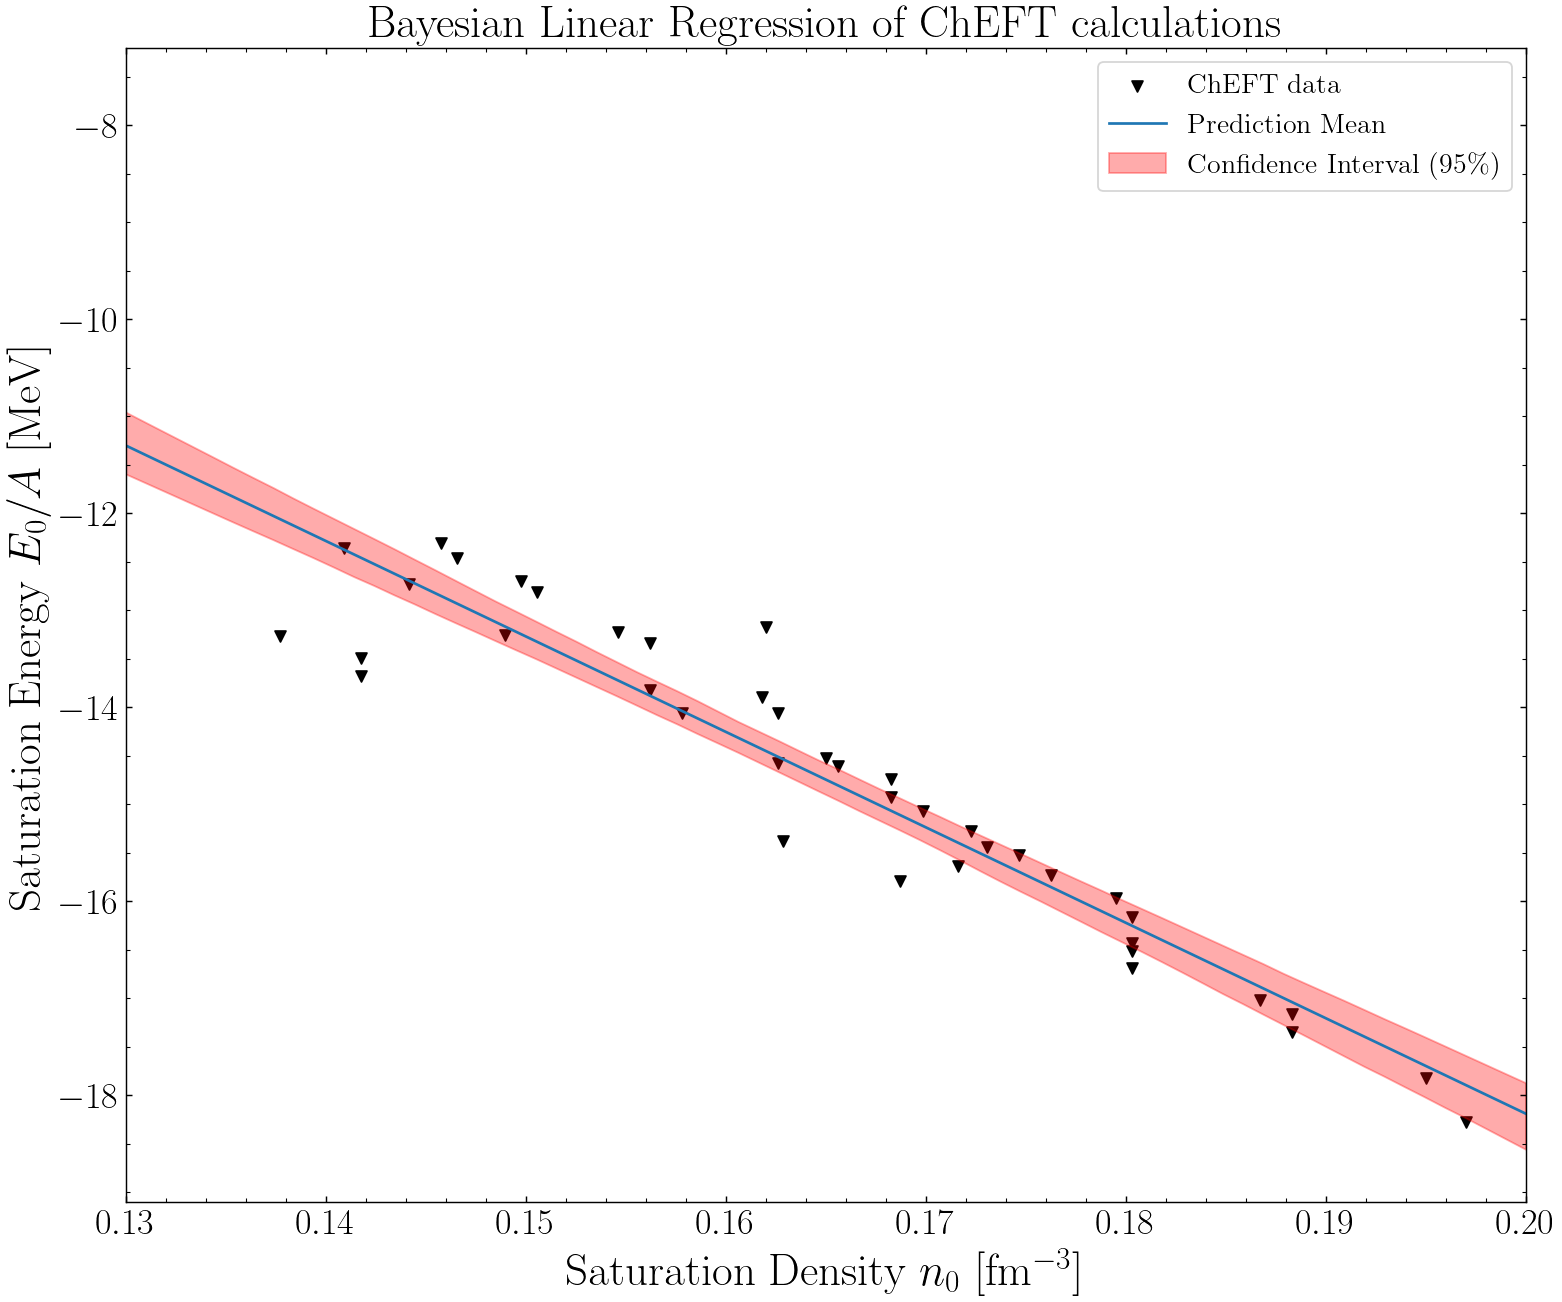

In [6]:
density = np.linspace(.1,.2,100)
sumArray = [0] * 100
for i in range(100):
    for line in range(len(trace)):
        sumArray[i] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i]) + sumArray[i]
    sumArray[i] = sumArray[i] / len(trace)

y_average = sumArray
y_max = [0] * 100
y_min = [0] * 100
temp_array = [0] * len(trace)

for i in range(100):
    for line in range(len(trace)):
          temp_array[line] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i])
    temp_array = np.sort(temp_array)
    y_max[i] = temp_array[974] 
    y_min[i] = temp_array[25]
    

plt.figure(figsize=(12, 10), constrained_layout=True)
plt.xlim([.13,.2])
plt.scatter(x, y, c='black', marker='v', label='ChEFT data')
plt.title(label = 'Bayesian Linear Regression of ChEFT calculations',fontdict = {'fontsize' : 25})
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]',fontdict = {'fontsize' : 25})
plt.ylabel('Saturation Energy $E_0/A$ [MeV]',fontdict = {'fontsize' : 25})
plt.plot(density, y_average, label='Prediction Mean')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.legend()
plt.fill_between(density, y_min , y_max , color='r', alpha=.33, label= 'Confidence Interval ($95\%$)')
plt.legend(loc='upper right',fontsize='xx-large')
plt.savefig("BayesianLinRegChEFT.pdf")

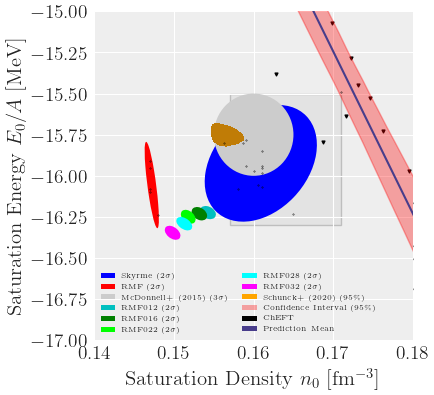

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(11*cm, 10*cm), constrained_layout=True)

legend_elements=[]
for imodel,model in enumerate(("Skyrme", "RMF",)):
    masked_data=data[data["type"]==model]
    color=colorset[imodel]
    confidence_ellipse(masked_data["rho0"], masked_data["E/A"], 
                       ax, n_std=2.0, facecolor=color, show_scatter=True)
    legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor=color, label=f"{model} (2$\\sigma$)"))
    

plot_empirical_saturation(ax=ax, zorder=-3)

color=facecolor="0.8"

confidence_ellipse_mean_cov([np.mean([0.155,0.165]),np.mean([-16, -15.5])], np.diag([0.005,0.25])**2, 
                            ax=ax, n_std=1, facecolor="0.8")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor=color, label=f"McDonnell+ (2015) (3$\\sigma$)"))
# 0.155 ≤ ρc ≤ 0.165 (fm−3 ); −16.0 ≤ E NM /A ≤ −15.5 (MeV);



def hartree_code(filepath):
    data = pd.read_fwf(filepath, comment='#', header=None)
    data_str = (data.loc[2,0])
    data_val = data_str.strip('][').split(', ')
    A_mean = float(data_val[0])
    B_mean = float(data_val[1])
    Cov = float(data_val[2])*float(data_val[3])*float(data_val[4])
    A_std = float(data_val[2])
    B_std = float(data_val[3])
    return (A_mean, B_mean, Cov, A_std, B_std)

A_12, B_12, Cov_12, A_std_12, B_std_12 = hartree_code("saturation/RMF012/CovEllipse.com")
A_16, B_16, Cov_16, A_std_16, B_std_16 = hartree_code("saturation/RMF016/CovEllipse.com")
A_22, B_22, Cov_22, A_std_22, B_std_22 = hartree_code("saturation/RMF022/CovEllipse.com")
A_28, B_28, Cov_28, A_std_28, B_std_28 = hartree_code("saturation/RMF028/CovEllipse.com") 
A_32, B_32, Cov_32, A_std_32, B_std_32 = hartree_code("saturation/RMF032/CovEllipse.com") 

confidence_ellipse_mean_cov(np.array([A_12, B_12]), np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]]),
                           ax=ax, n_std=2, facecolor="c")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="c", label=f"RMF012 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_16, B_16]), np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]]),
                           ax=ax, n_std=2, facecolor="g")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="g", label=f"RMF016 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_22, B_22]), np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]]),
                           ax=ax, n_std=2, facecolor="lime")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="lime", label=f"RMF022 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_28, B_28]), np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]]),
                           ax=ax, n_std=2, facecolor="aqua")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="aqua", label=f"RMF028 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_32, B_32]), np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]]),
                           ax=ax, n_std=2, facecolor="magenta")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="magenta", label=f"RMF032 (2$\\sigma$)"))

def plotkde(filename):
    data1 = np.loadtxt(filename, delimiter=',', skiprows=1)
    sns.kdeplot(x=data1[:,0], y=data1[:,1], fill=True, levels=[.05,1], color="orange")
    legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="orange", label=f"Schunck+ (2020) (95\%)"))   
     
plotkde("data/forChristan_samples1.csv")
#plotkde("data/forChristan_samples2.csv")
#plotkde("data/forChristan_samples3.csv")

density = np.linspace(.1,.2,100)
sumArray = [0] * 100
for i in range(100):
    for line in range(len(trace)):
        sumArray[i] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i]) + sumArray[i]
    sumArray[i] = sumArray[i] / len(trace)

y_average = sumArray
y_max = [0] * 100
y_min = [0] * 100
temp_array = [0] * len(trace)

for i in range(100):
    for line in range(len(trace)):
          temp_array[line] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i])
    temp_array = np.sort(temp_array)
    y_max[i] = temp_array[974] 
    y_min[i] = temp_array[25] 
    
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="r", alpha=.33, label=f"Confidence Interval ($95\%$)"))    
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="k", label=f"ChEFT"))
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor="darkslateblue", label=f"Prediction Mean"))
plt.scatter(x, y, s=4, c='black', label='ChEFT', marker='v')    
plt.plot(density, y_average, label='Prediction Mean', c='darkslateblue')    
plt.fill_between(density, y_min , y_max , color='r', alpha=.33, label= 'Confidence Interval ($95\%$)')
ax.legend(handles=legend_elements, loc='best', fontsize='xx-small', ncol=2)
#ax.axvspan(.155,.165,alpha=.2)

ax.set_xlim(0.14, 0.18)
ax.set_ylim(-17, -15.)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
fig.savefig("saturationBayes.pdf")